['x.csv', 'z.csv']


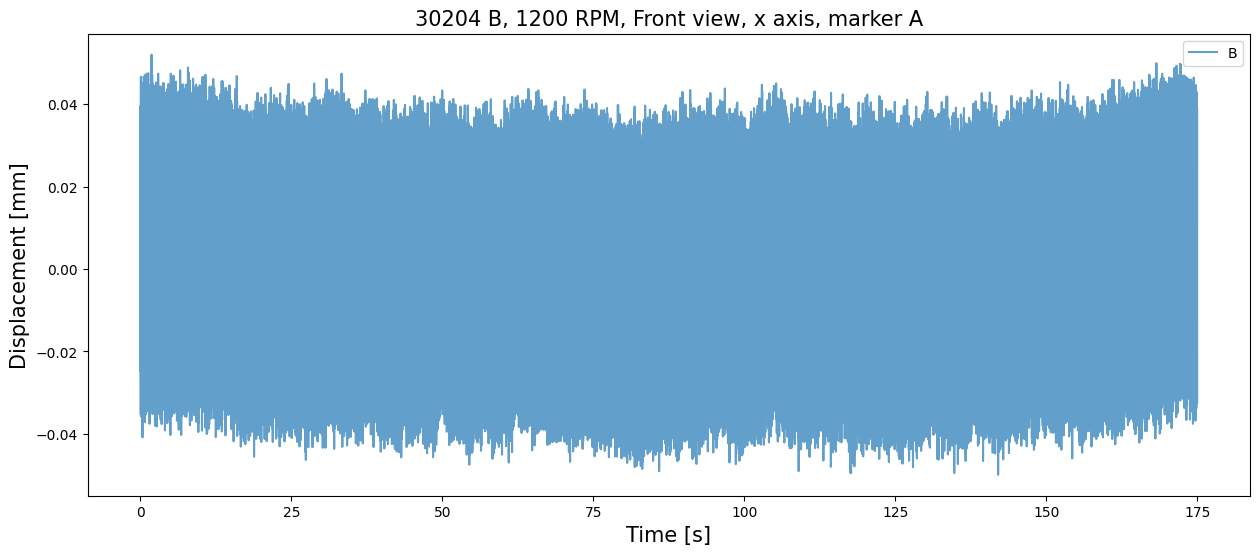

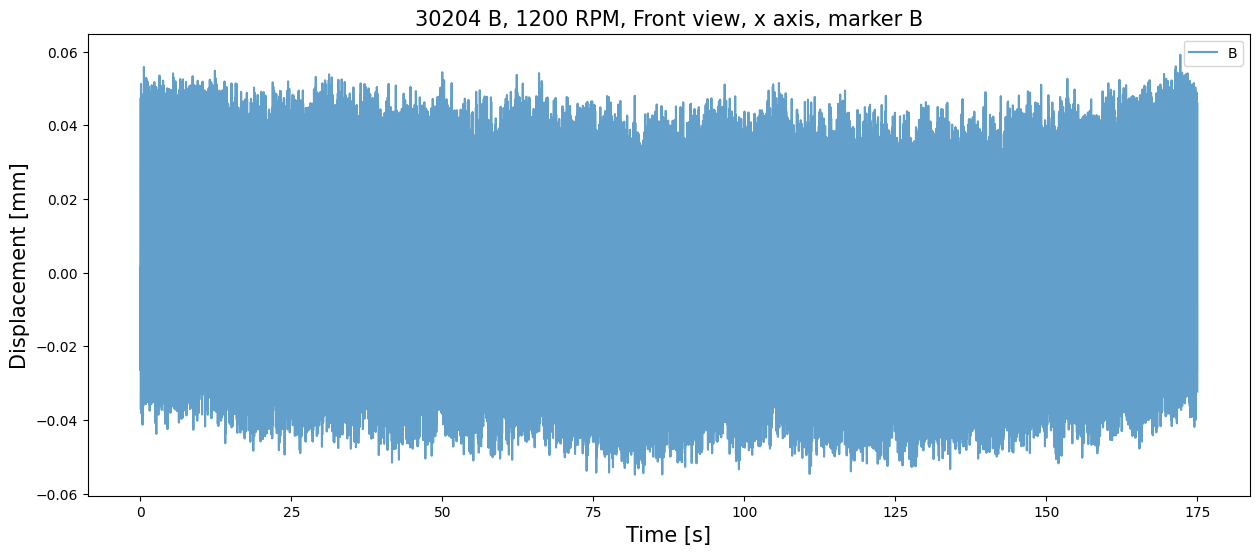

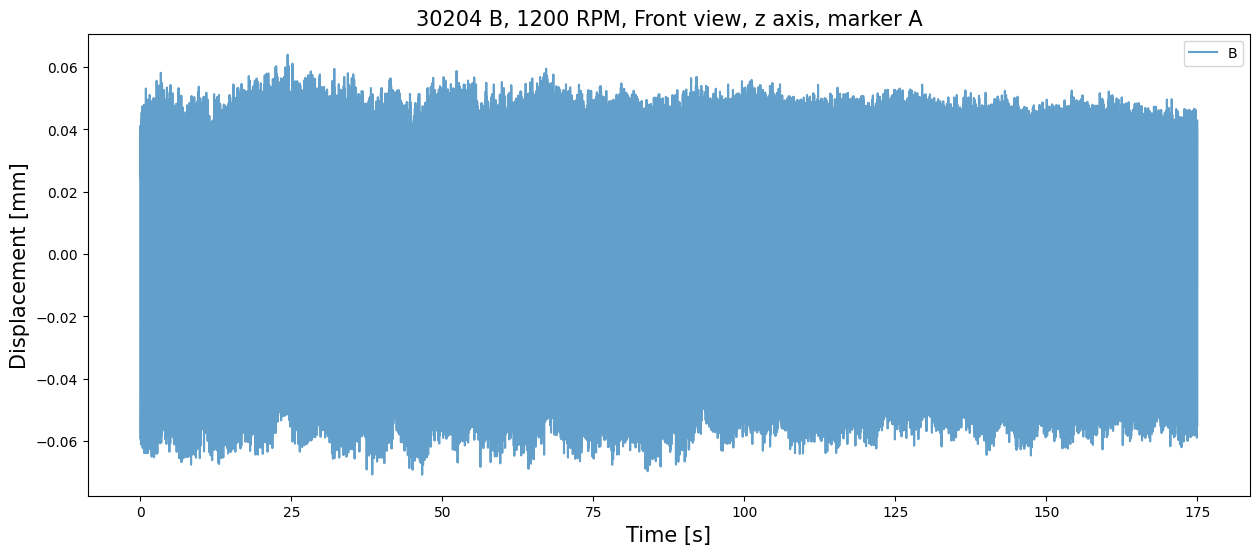

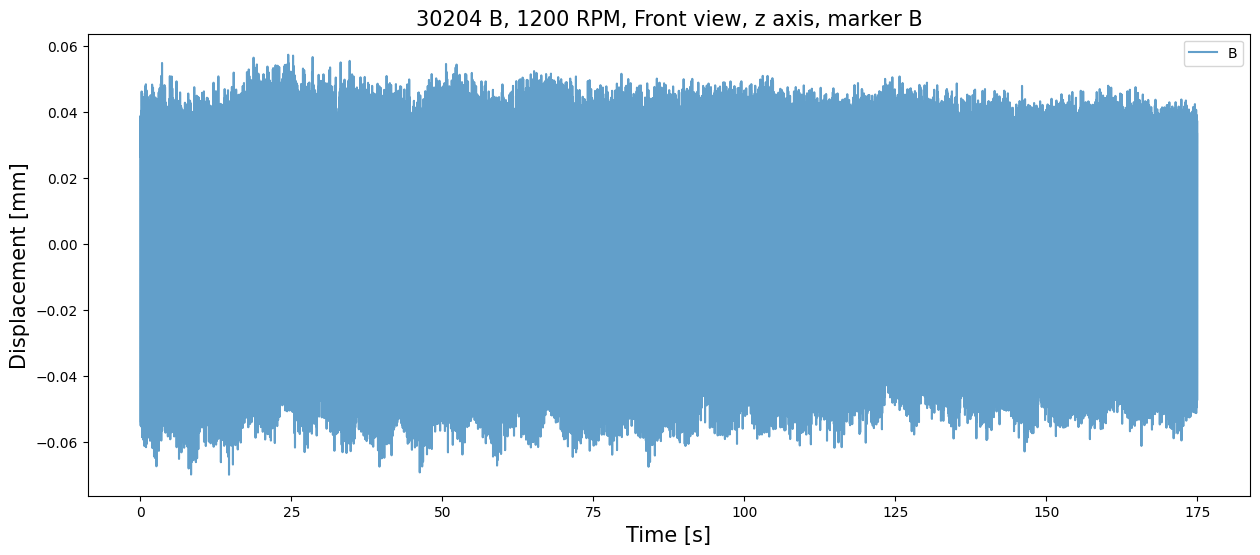

['y.csv', 'z.csv']


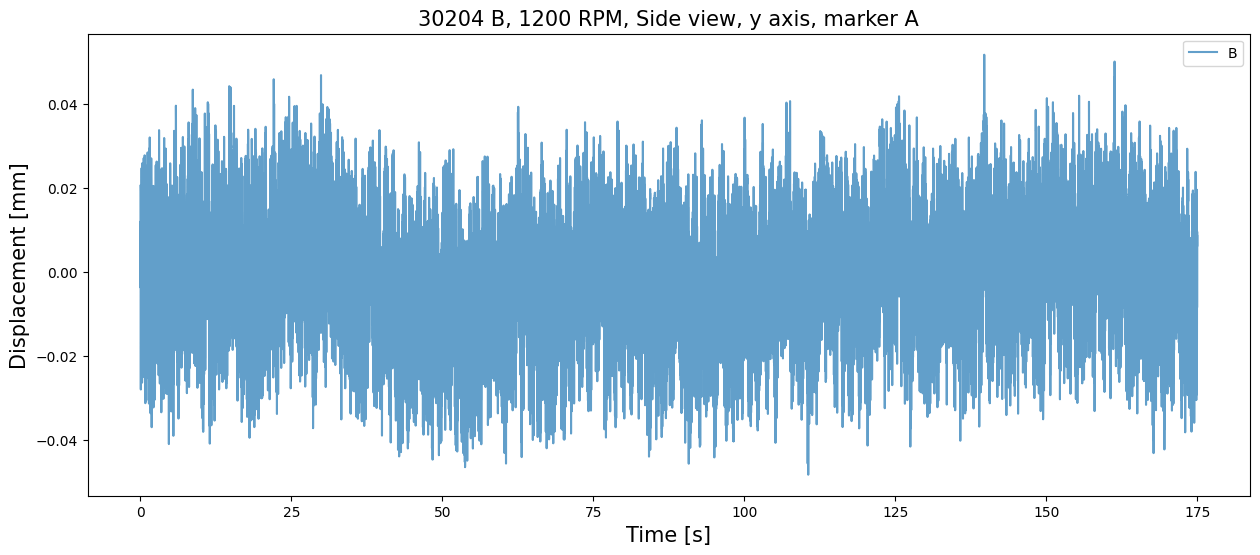

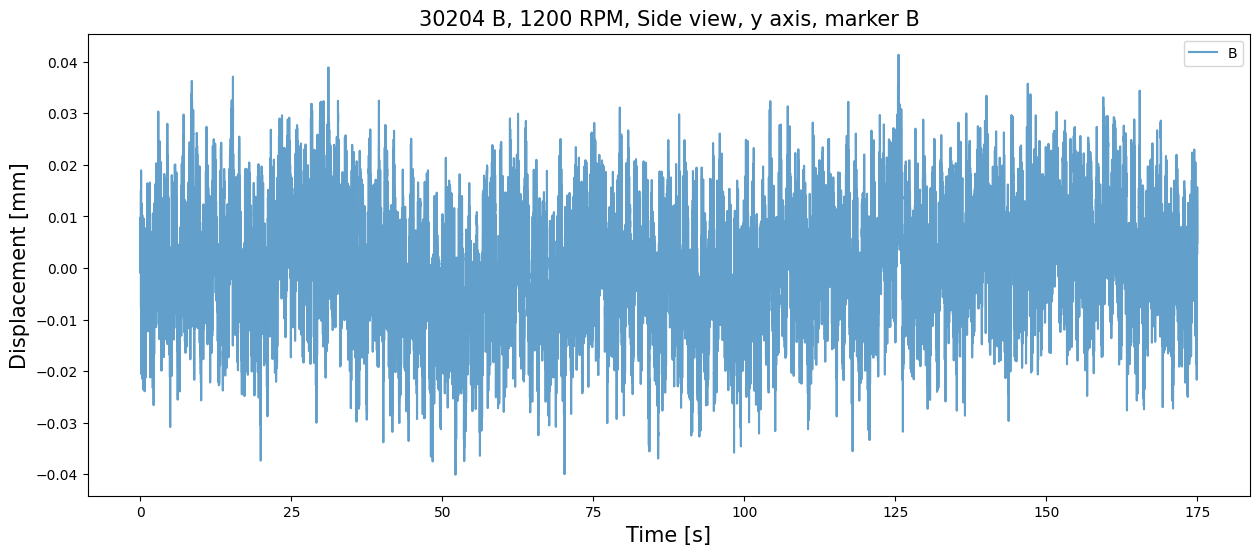

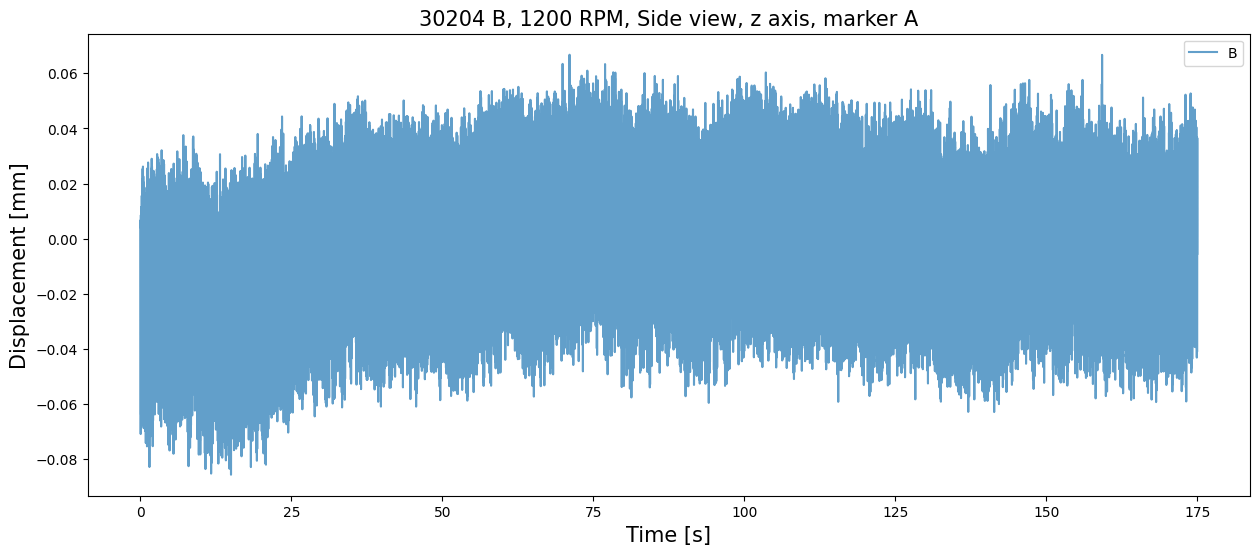

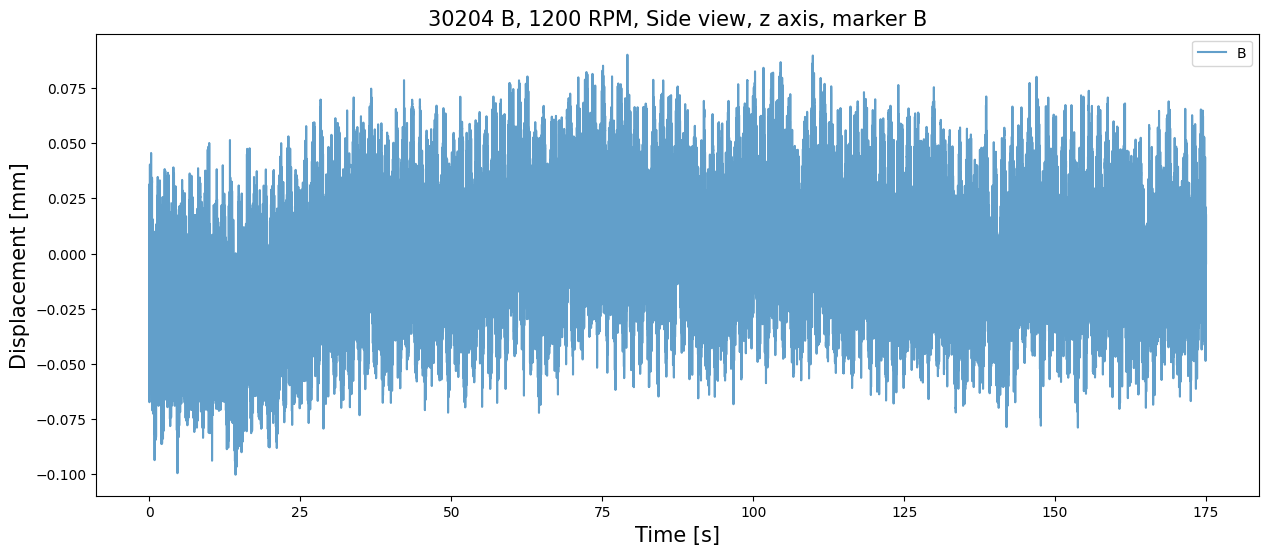

['x.csv', 'z.csv']


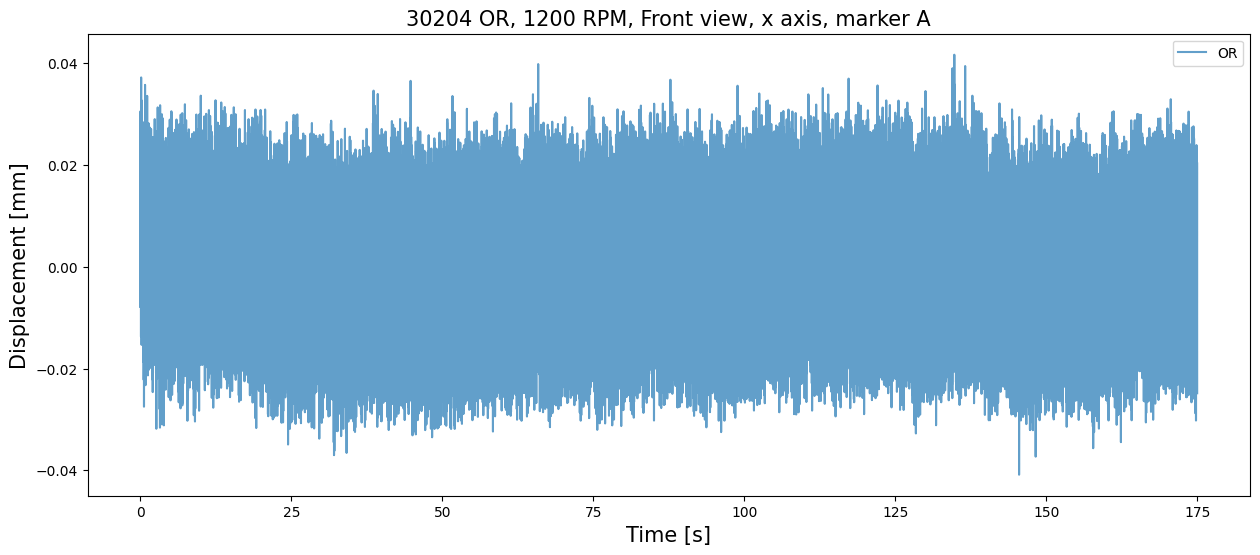

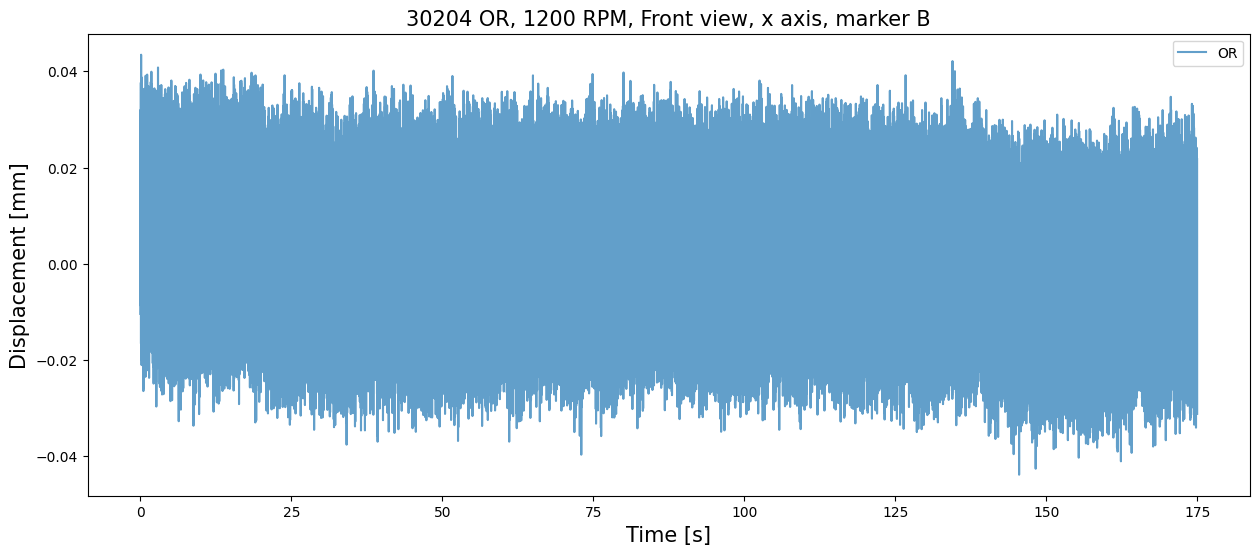

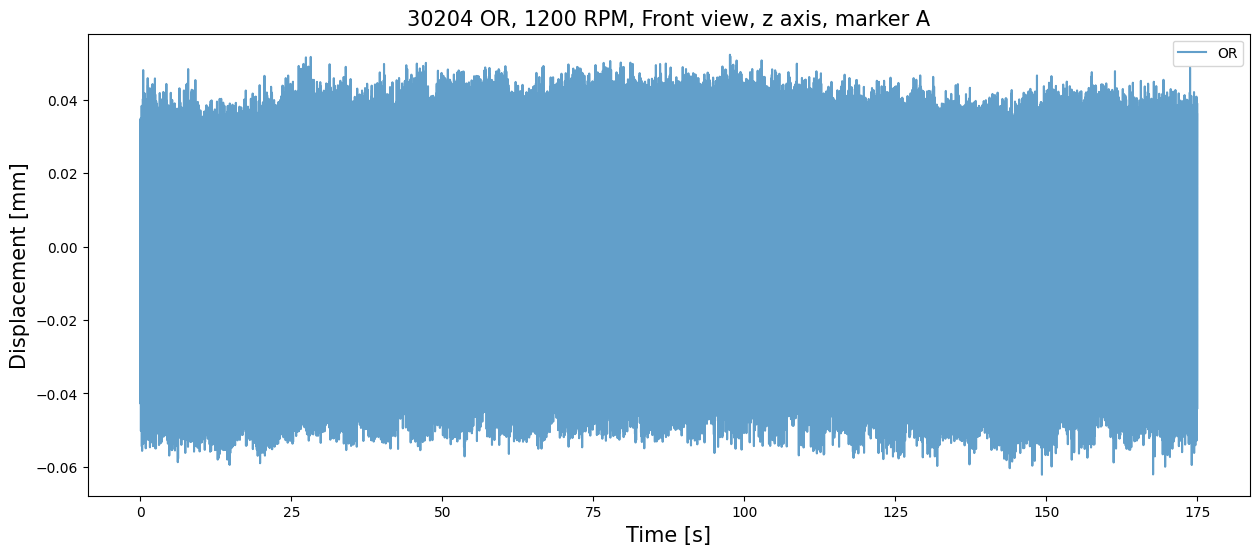

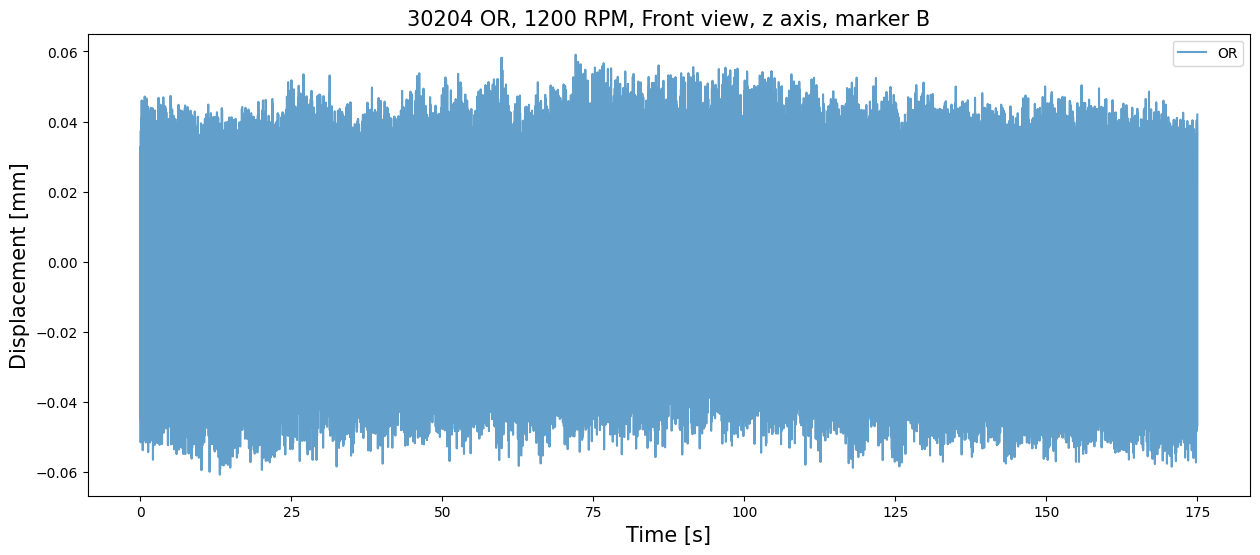

['y.csv', 'z.csv']


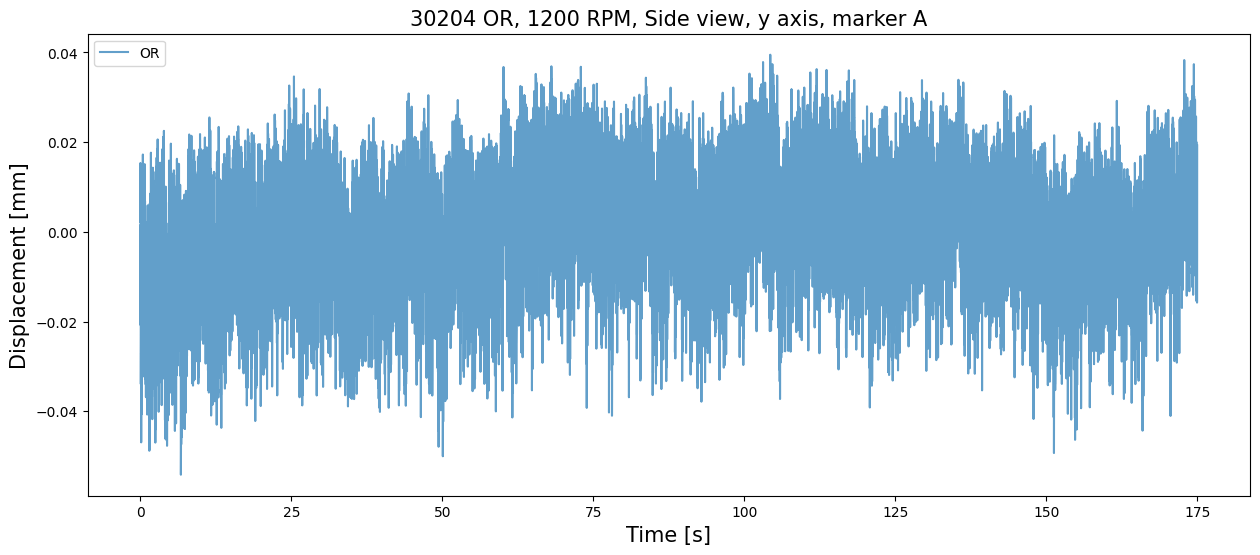

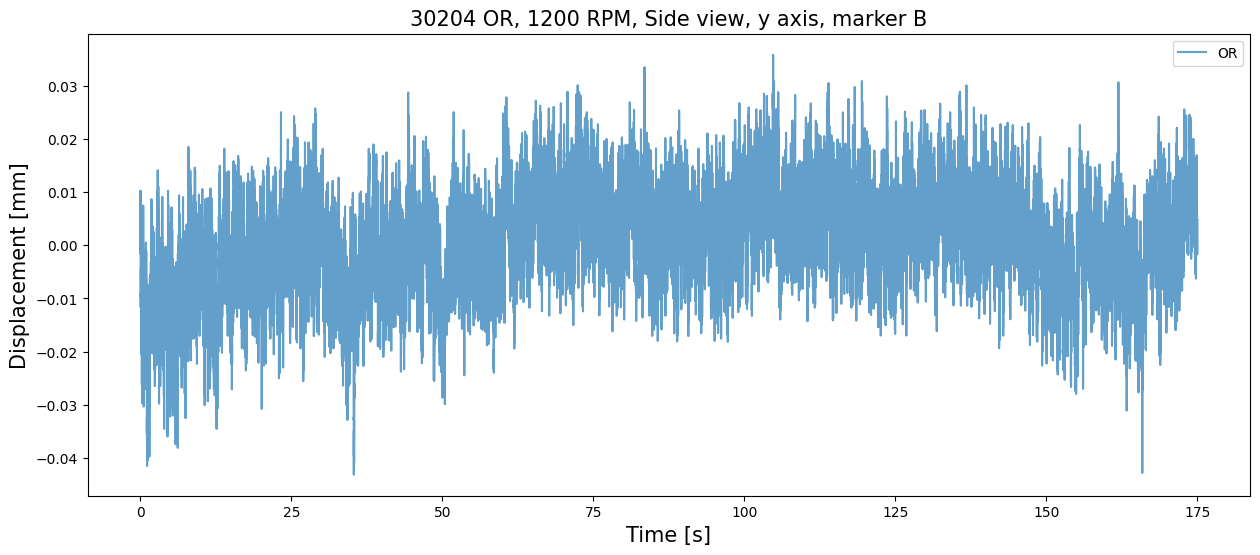

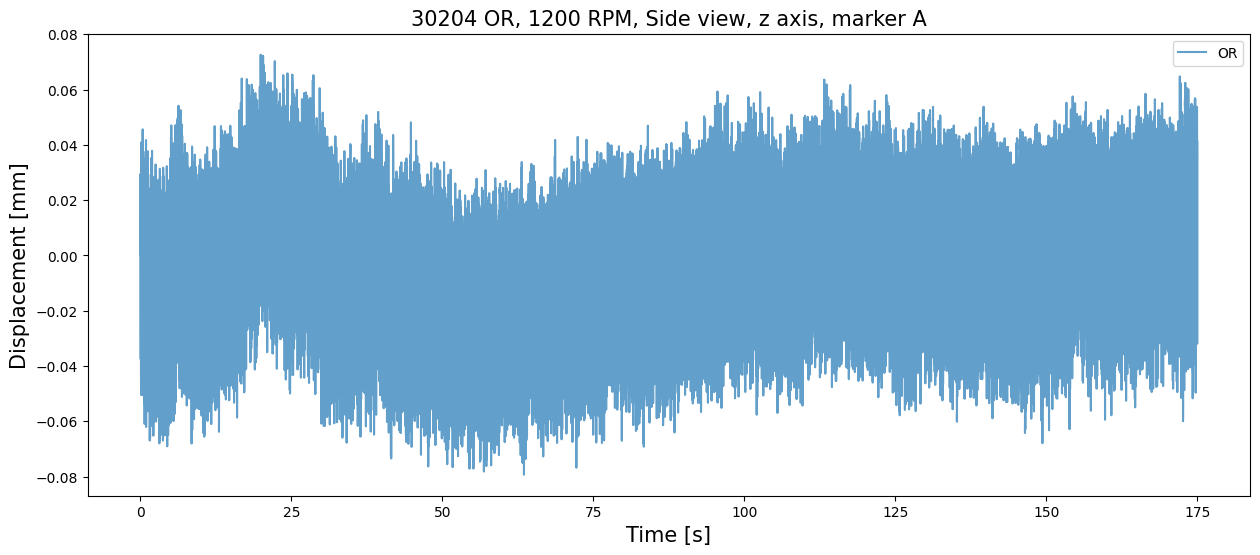

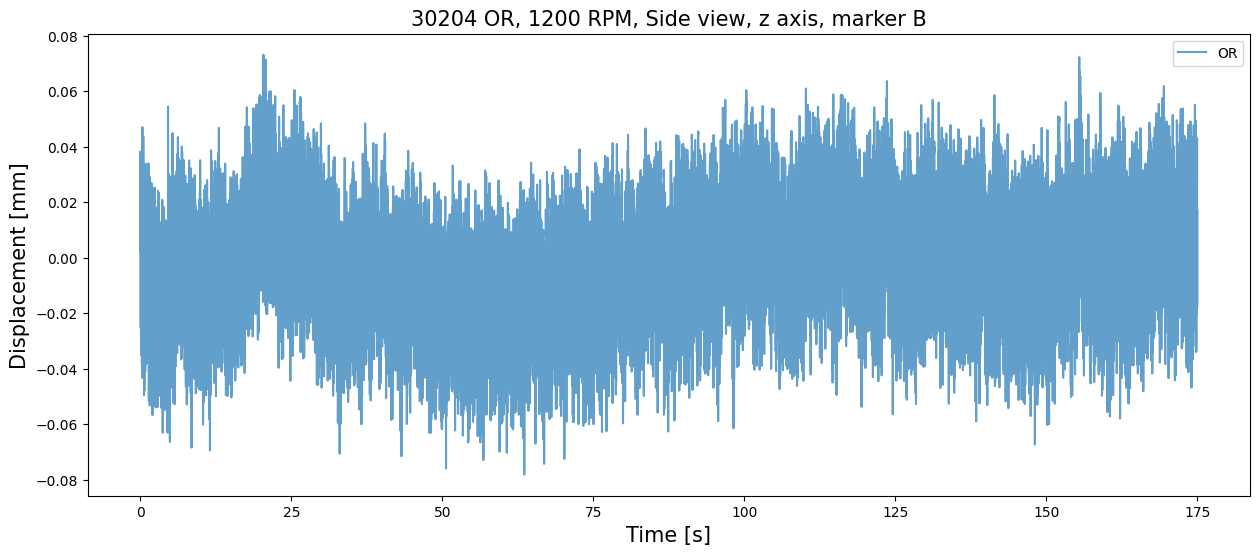

['x.csv', 'z.csv']


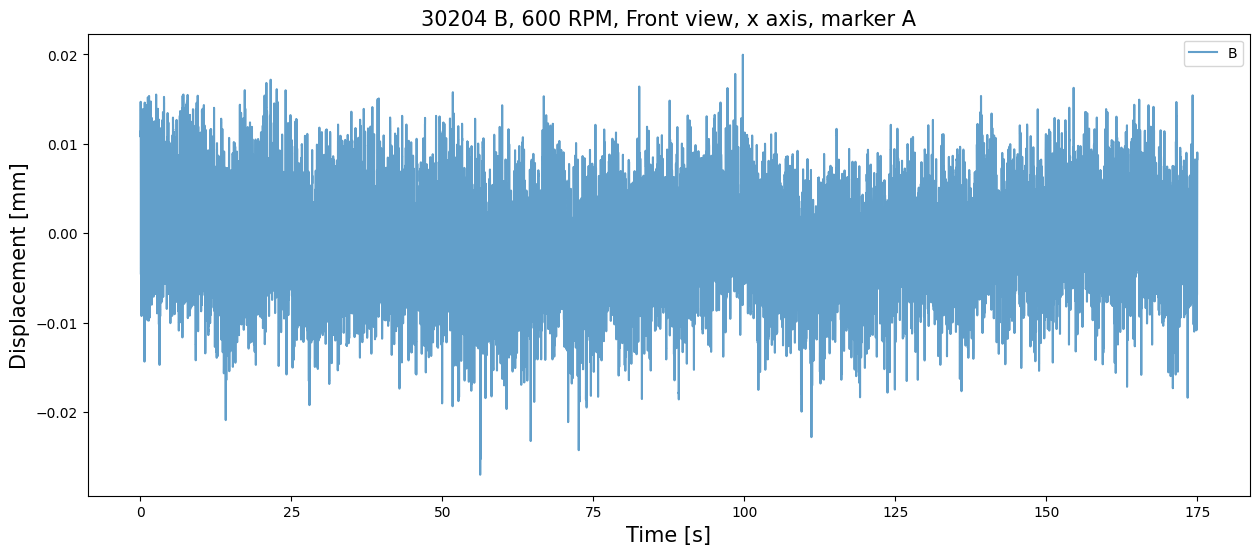

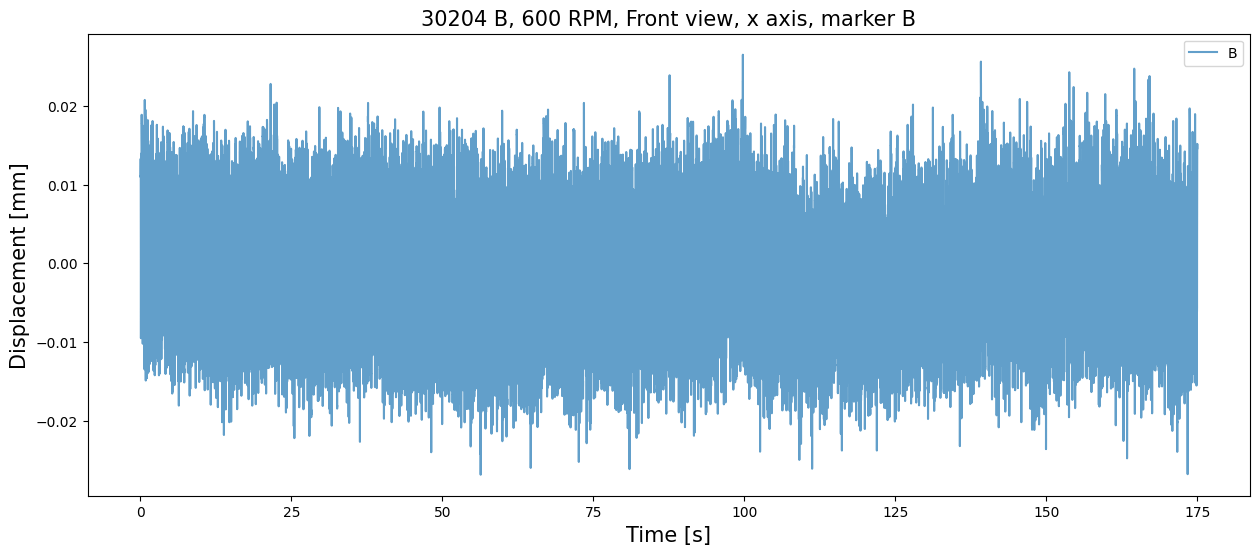

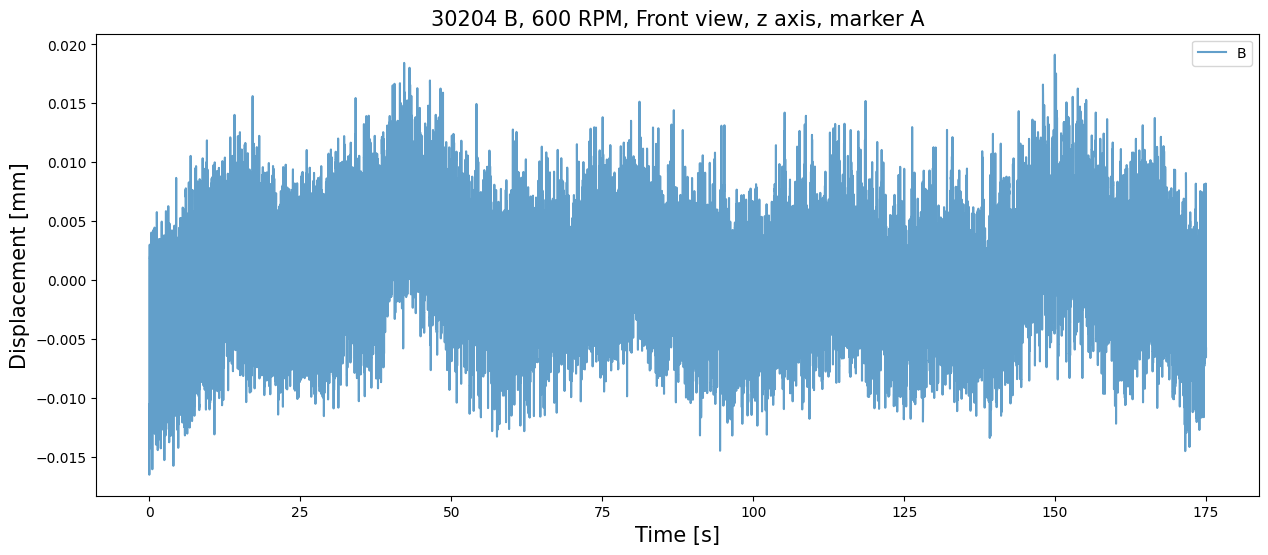

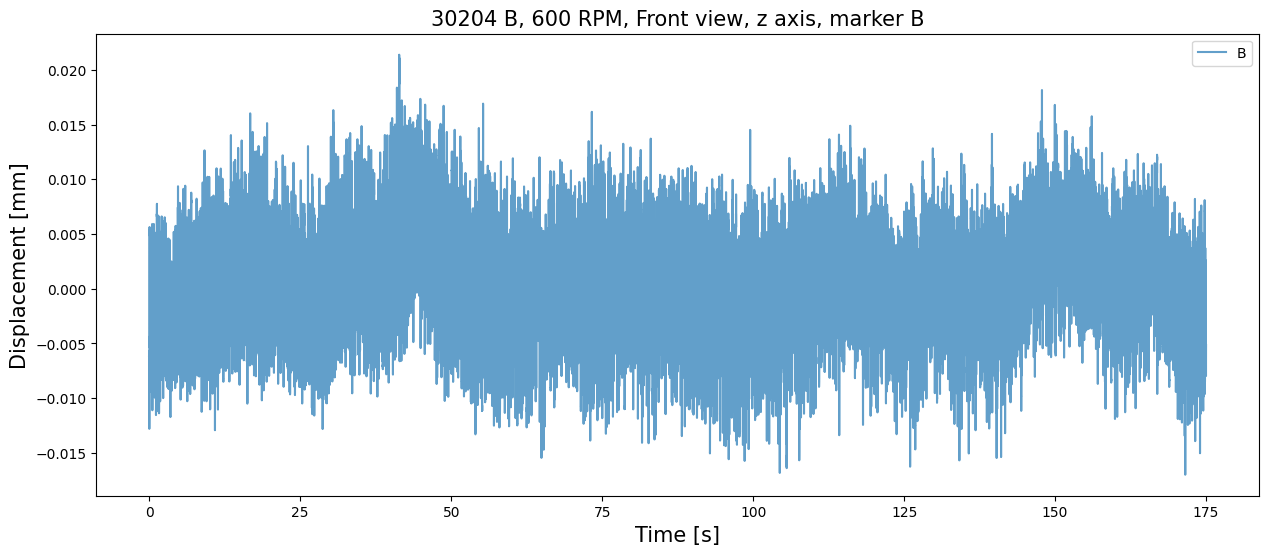

['y.csv', 'z.csv']


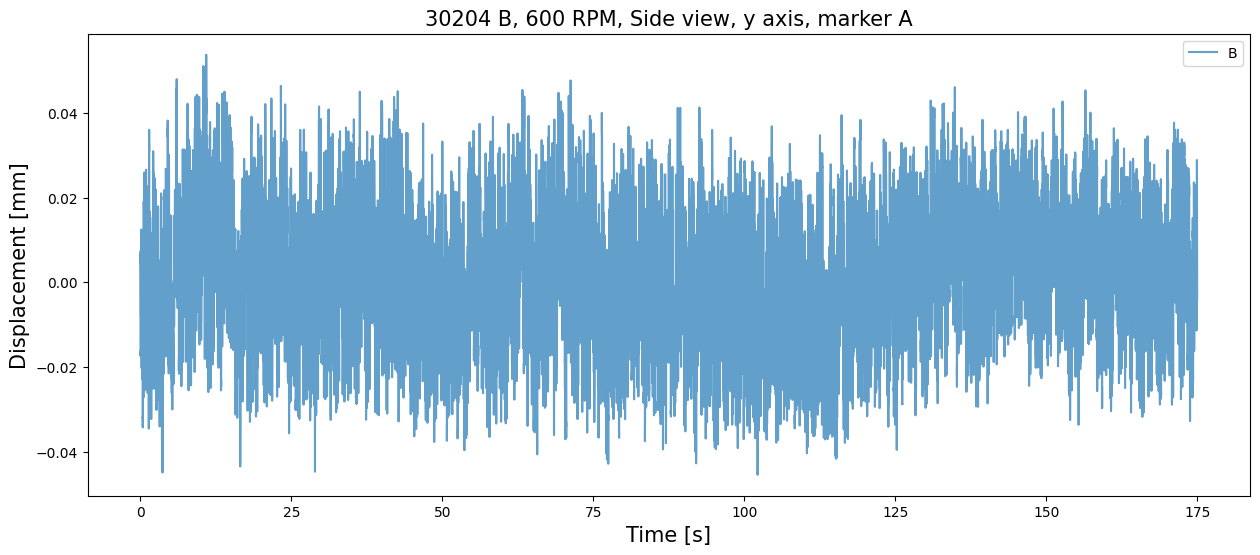

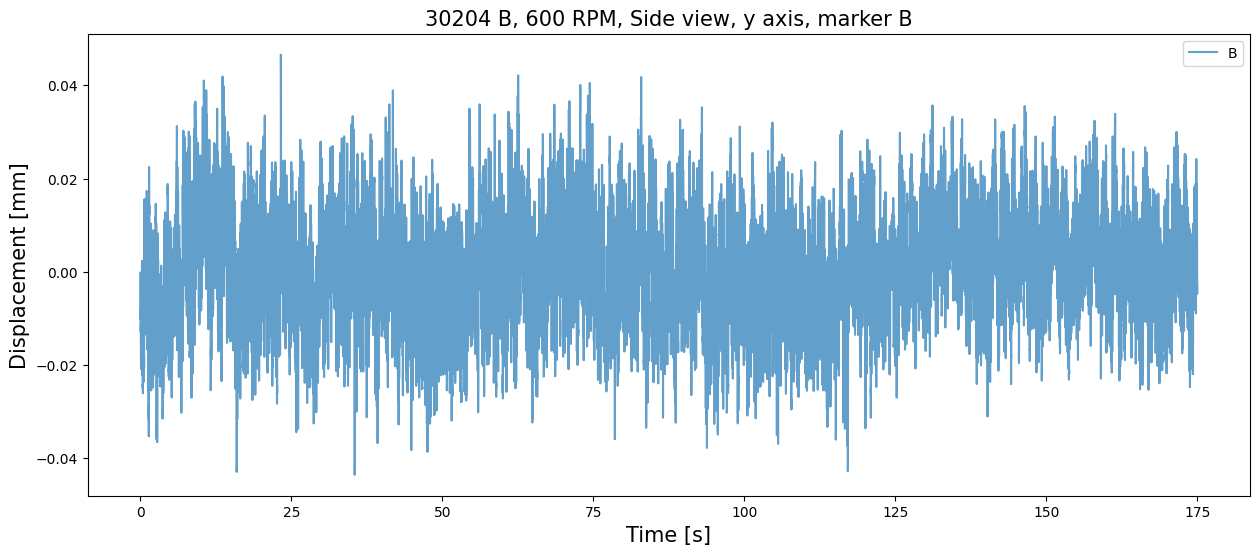

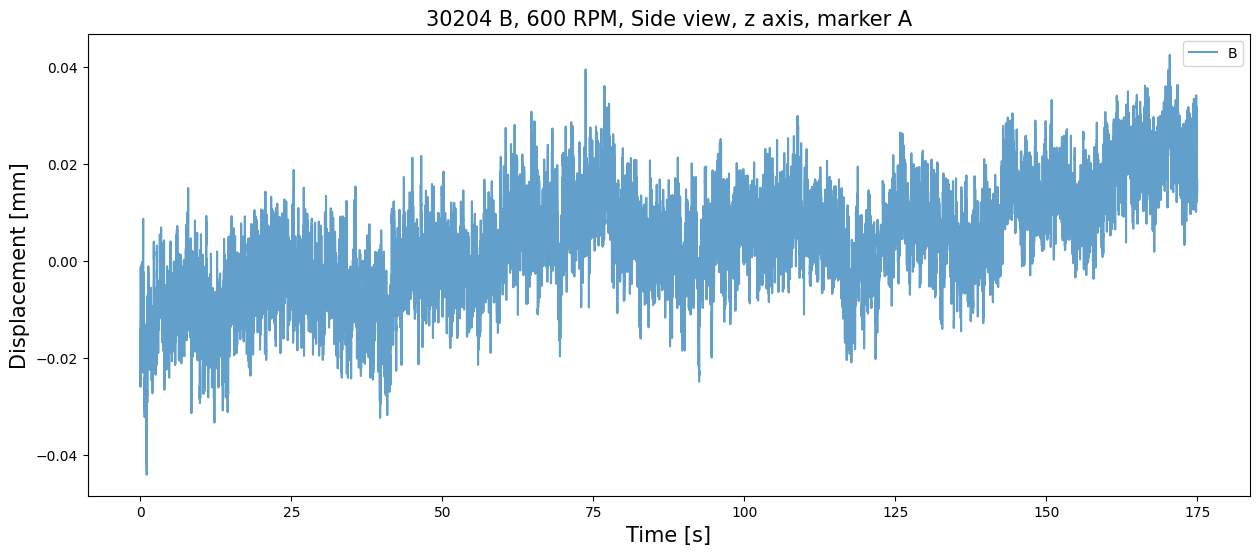

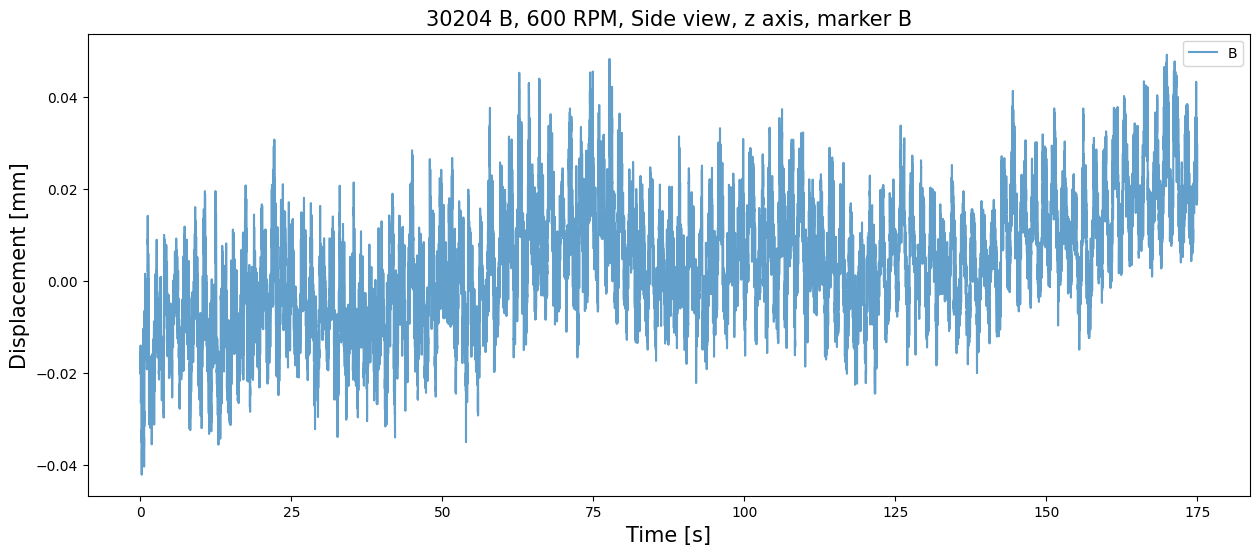

In [1]:
from funs import *

#####################################
# 그래프 보고자 하는 타겟 디렉토리 설정     
target_dir = '../output/1008'
######################################

dir_list = get_dir_list(target_dir)
draw_single_graphs(dir_list, ['x.csv', 'y.csv', 'z.csv'])

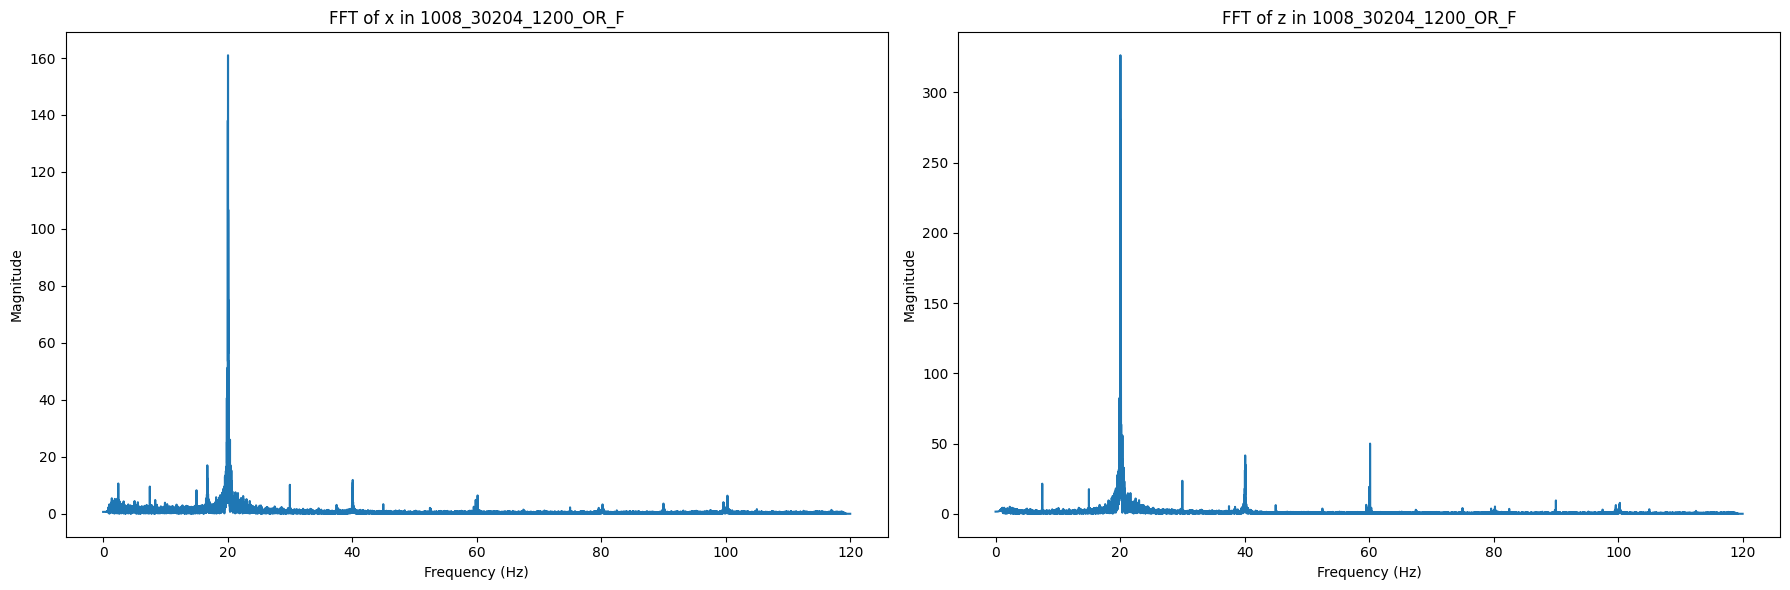

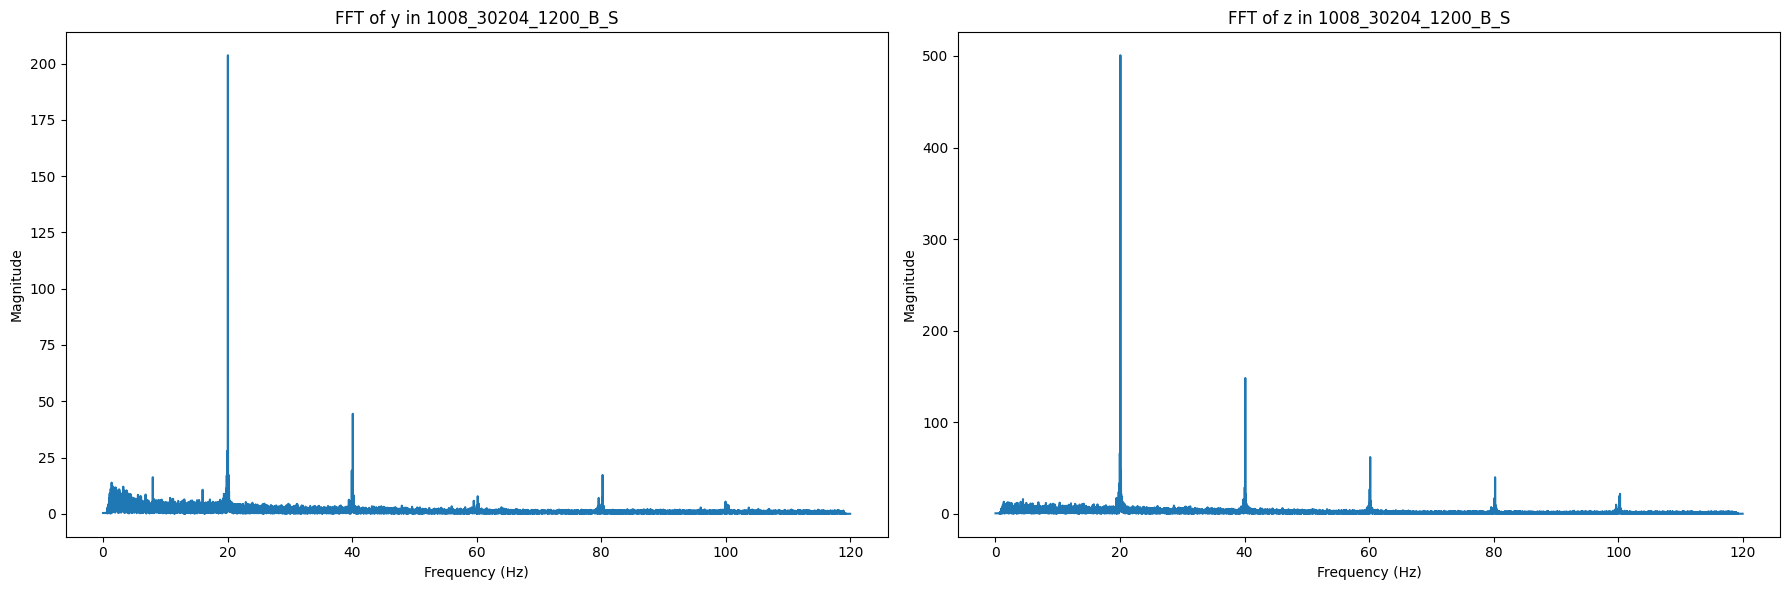

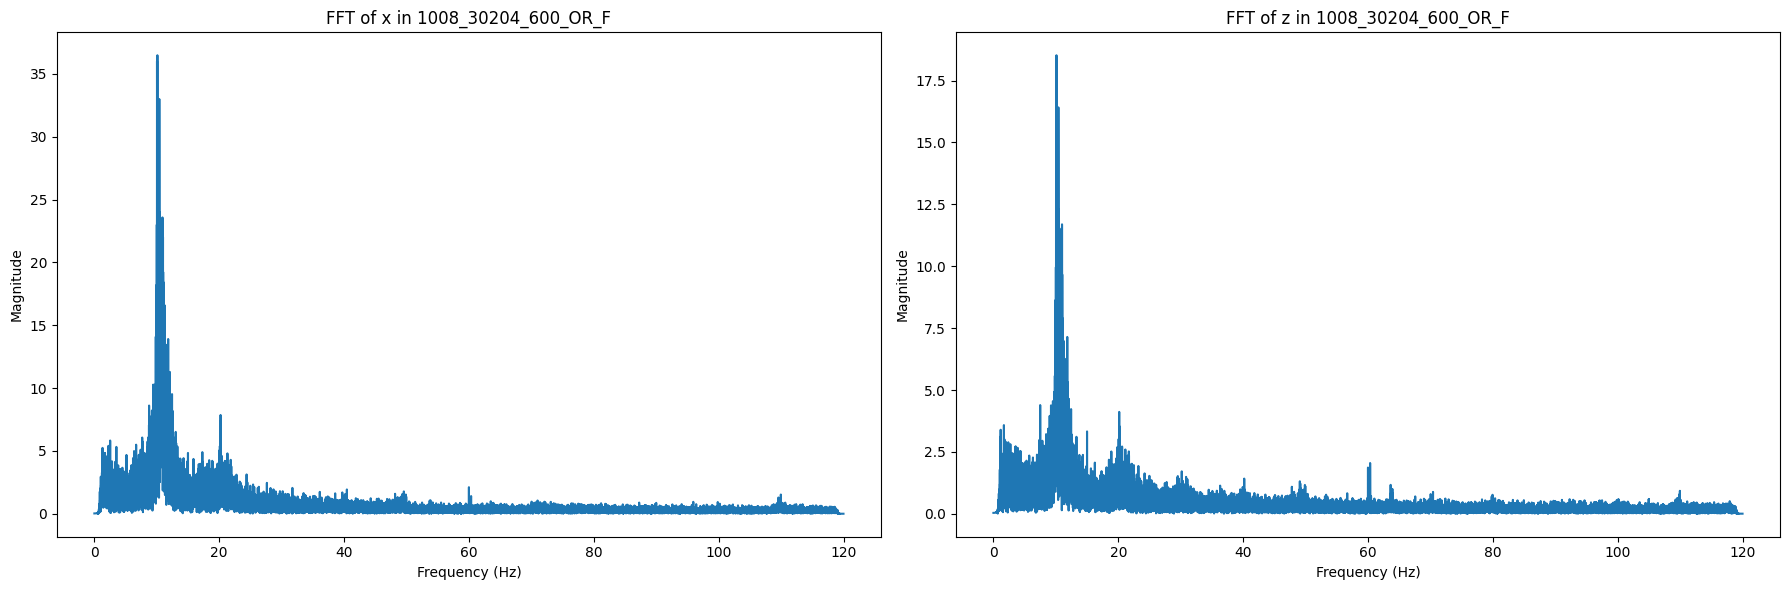

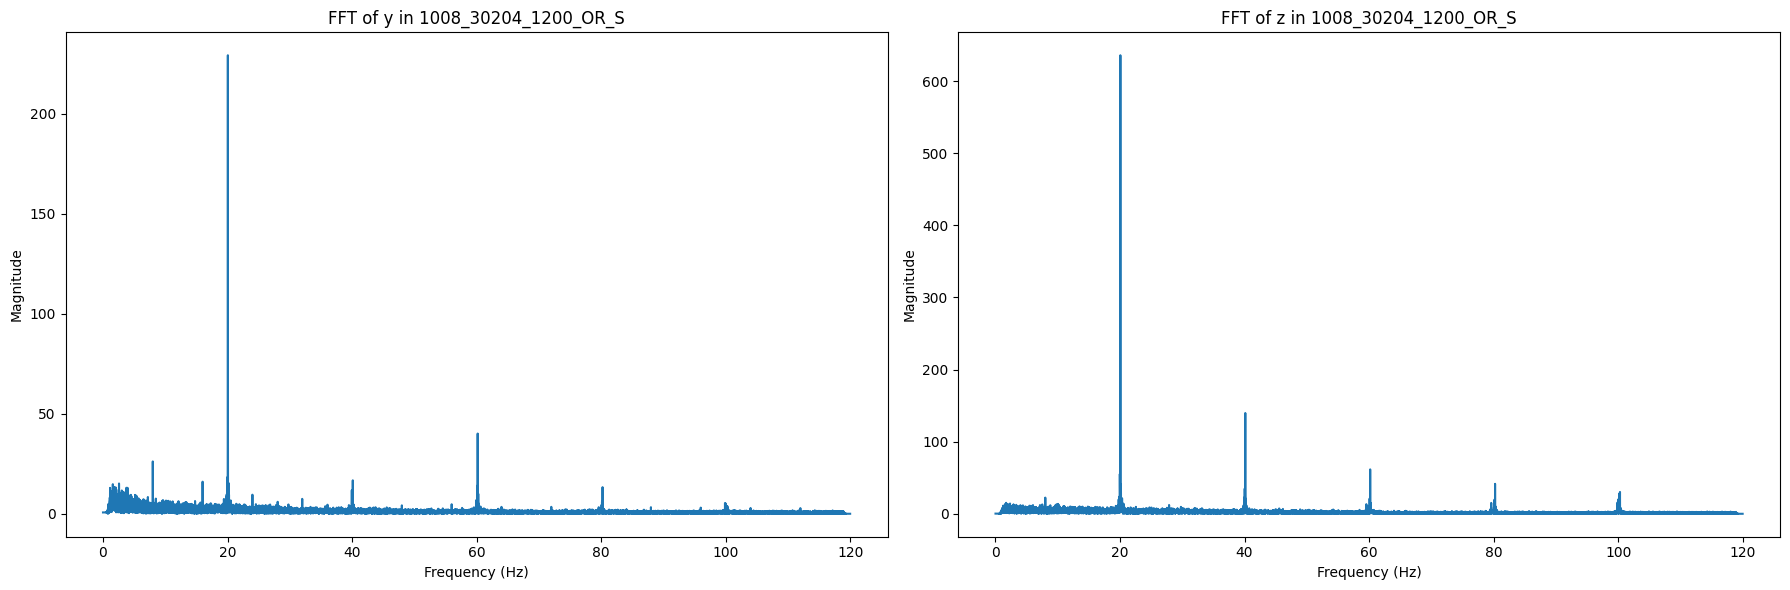

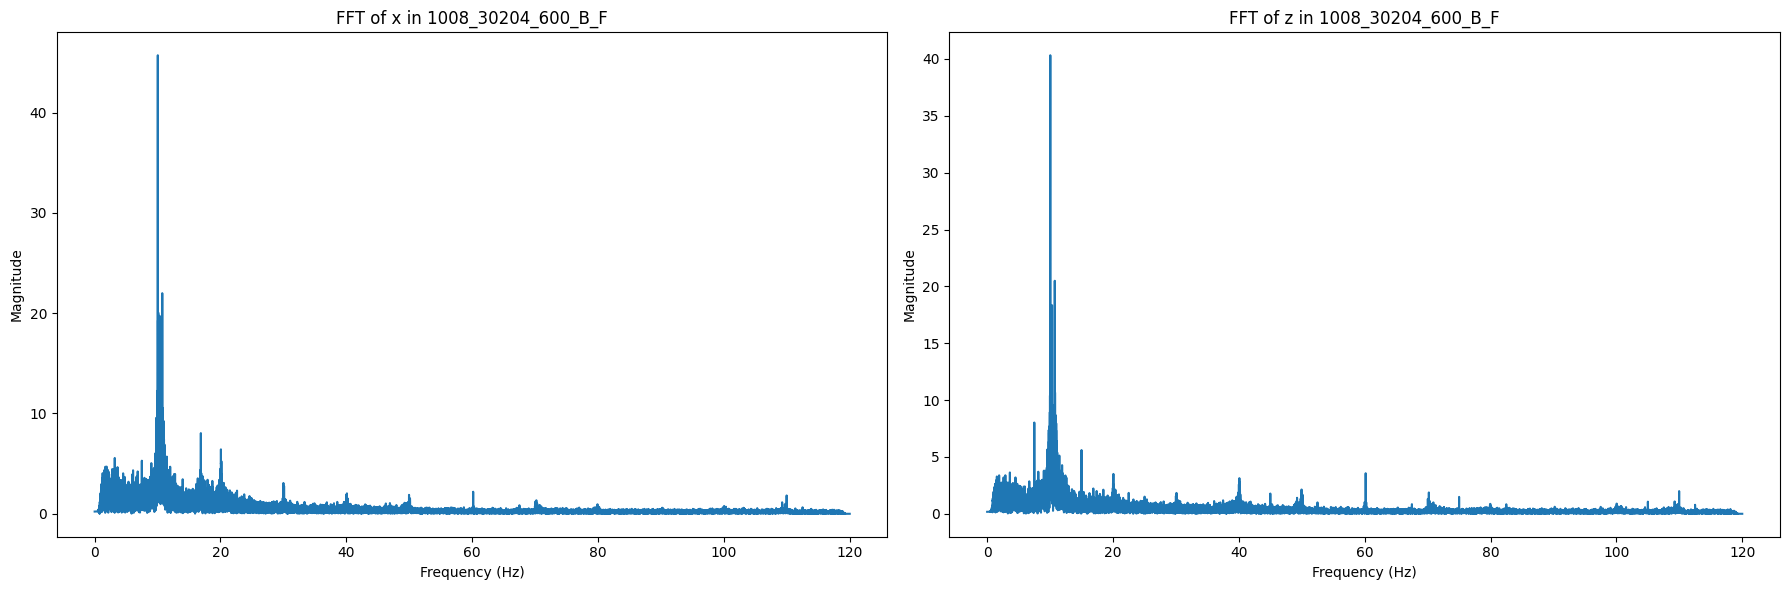

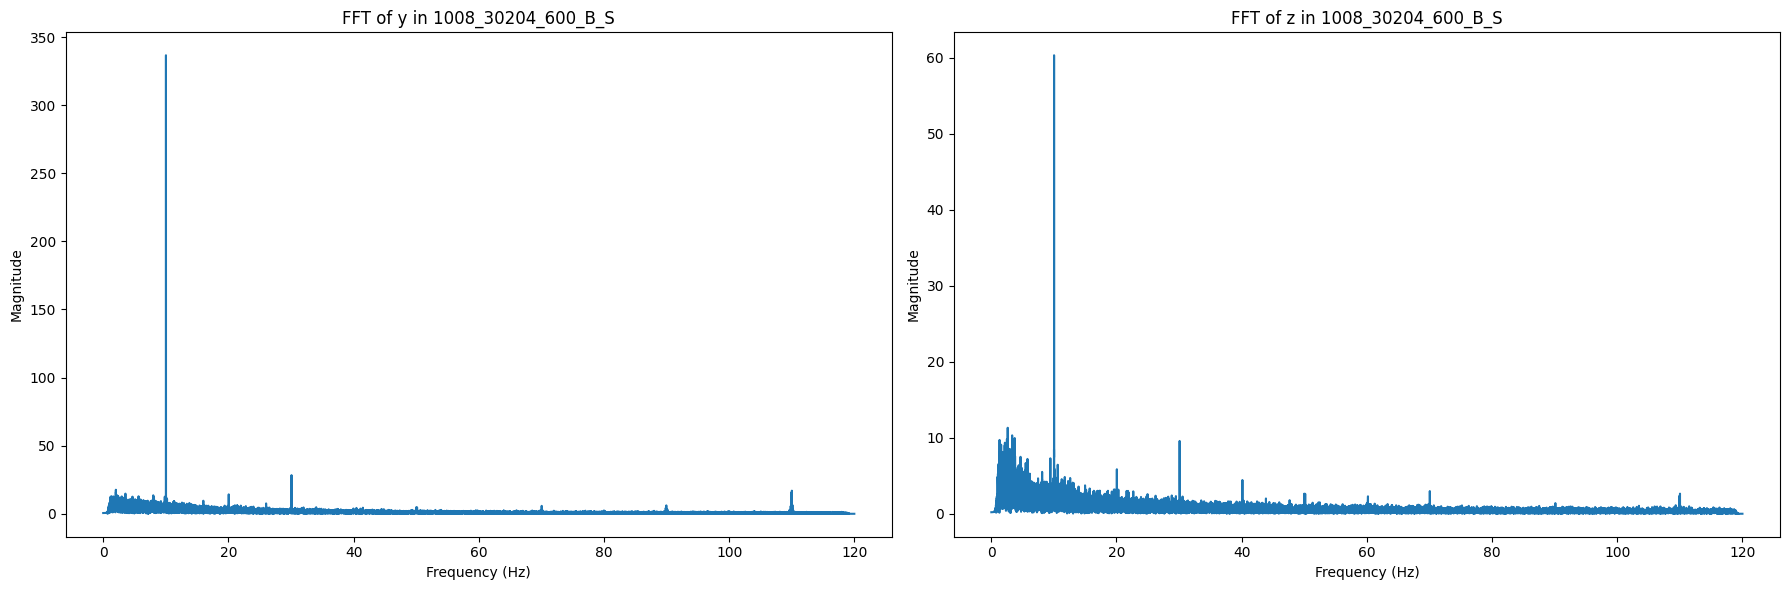

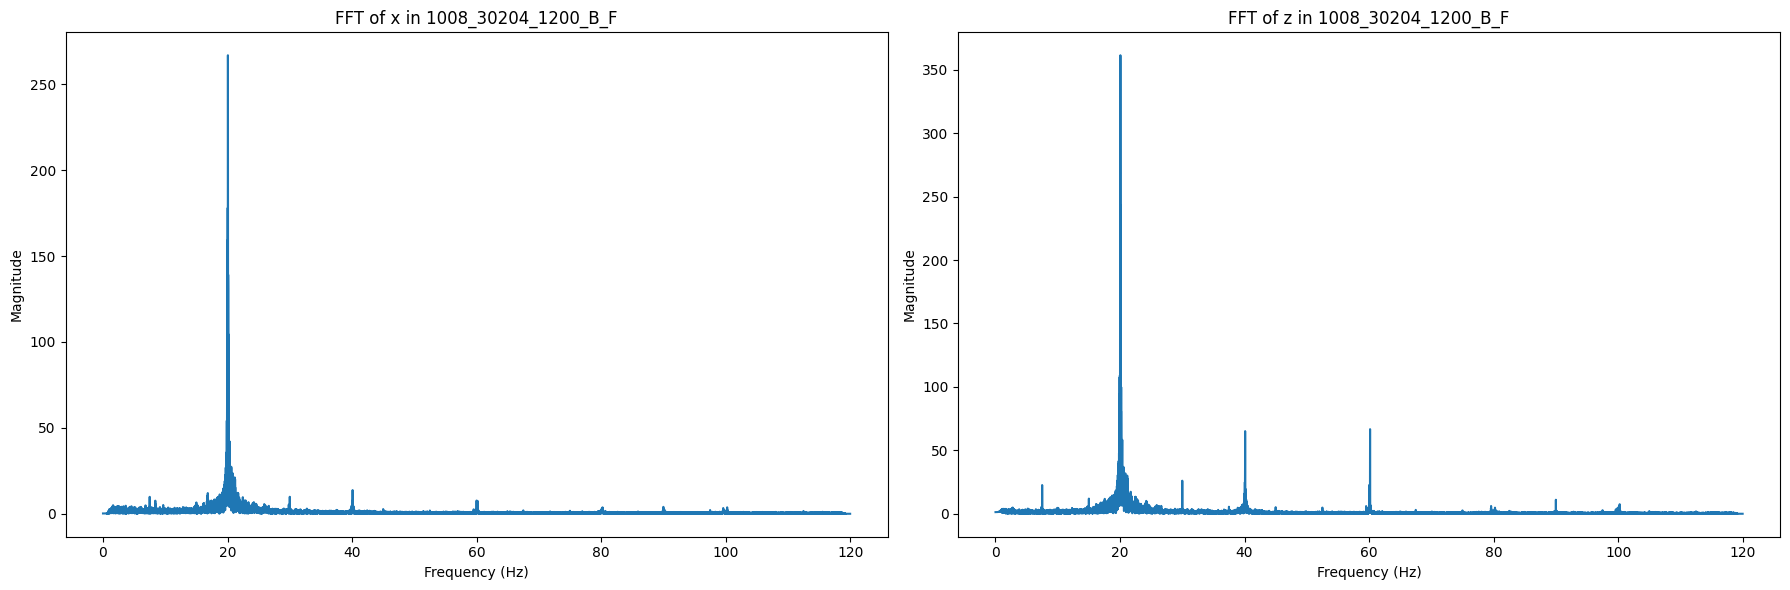

In [3]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert

# Base directory
base_dir = '/home/ktw/X-twice/MDPS-vis-master/output/1008/'

# 뒷부분 자르기
x_len = 240 * 175

# Sampling frequency
fps = 240

# Design bandpass filter
lowcut = 1.0
highcut = 119.0
nyquist = 0.5 * fps
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

# Conversion factors for different views and axes
conversion_factors = {
    '1001': {'F': 0.074627, 'S': 0.111111},
    '1008': {'F': 0.075757576, 'S': 0.177777778}
}

def process_and_plot(file_paths, dir_name):
    data = {}
    parts = dir_name.split('_')
    date = parts[0]
    axis = parts[-1]

    # Determine the conversion factor
    conversion_factor = conversion_factors.get(date, {}).get(axis, 1)

    for axis, file_path in file_paths.items():
        values = pd.read_csv(file_path).iloc[:x_len, 0].values
        # Apply conversion factor
        values = values * conversion_factor
        data[axis] = values

    # Apply bandpass filter and perform FFT
    fft_results = {}
    envelope_fft_results = {}
    for axis, values in data.items():
        filtered_values = filtfilt(b, a, values)
        envelope = np.abs(hilbert(filtered_values))
        fft_results[axis] = np.fft.fft(filtered_values)
        envelope_fft_results[axis] = np.fft.fft(envelope)
    
    # Compute frequencies
    freqs = np.fft.fftfreq(len(next(iter(data.values()))), 1/fps)
    freqs = np.fft.fftshift(freqs)
    
    # Plot the results
    plt.figure(figsize=(18, 6))
    for i, (axis, fft_result) in enumerate(fft_results.items(), 1):
        fft_result = np.fft.fftshift(fft_result)
        envelope_fft_result = np.fft.fftshift(envelope_fft_results[axis])
        positive_freqs = (freqs > 0) & (freqs <= 120)
        plt.subplot(1, len(fft_results), i)
        plt.plot(freqs[positive_freqs], np.abs(fft_result[positive_freqs]))
        plt.title(f'FFT of {axis} in {dir_name}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
    
    plt.tight_layout()
    plt.show()

# Walk through directories and process files
for root, dirs, files in os.walk(base_dir):
    file_paths = {}
    for file in files:
        if file in ['x.csv', 'y.csv', 'z.csv']:
            file_paths[file[0]] = os.path.join(root, file)
    
    if len(file_paths) >= 2:  # Ensure at least two files are present
        dir_name = os.path.basename(root)
        process_and_plot(file_paths, dir_name)

In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from tabulate import tabulate

# Base directory
base_dir = '/home/ktw/X-twice/MDPS-vis-master/output/1008/'

# 뒷부분 자르기
x_len = 240 * 175

# Conversion factors for different views and axes
conversion_factors = {
    '1001': {'F': 0.074627, 'S': 0.111111},
    '1008': {'F': 0.075757576, 'S': 0.177777778}
}

def calculate_statistics(values):
    peak = np.max(np.abs(values))
    average = np.mean(values)
    rms = np.sqrt(np.mean(values**2))
    crest_factor = peak / rms
    return peak, average, rms, crest_factor

def process_and_calculate(file_paths, dir_name):
    stats = []
    parts = dir_name.split('_')
    date = parts[0]
    axis = parts[-1]

    # Determine the conversion factor
    conversion_factor = conversion_factors.get(date, {}).get(axis, 1)
    for axis, file_path in file_paths.items():
        values = pd.read_csv(file_path).iloc[:x_len, 0].values
        # Apply conversion factor
        values = values * conversion_factor
        peak, average, rms, crest_factor = calculate_statistics(values)
        stats.append([dir_name, axis, peak, average, rms, crest_factor])
    
    return stats

# Walk through directories and process files
all_stats = []
for root, dirs, files in os.walk(base_dir):
    file_paths = {}
    for file in files:
        if file in ['x.csv', 'y.csv', 'z.csv']:
            file_paths[file[0]] = os.path.join(root, file)
    
    if len(file_paths) >= 2:  # Ensure at least two files are present
        dir_name = os.path.basename(root)
        stats = process_and_calculate(file_paths, dir_name)
        all_stats.extend(stats)

# Create DataFrame for the results
columns = ['Directory', 'Axis', 'Peak', 'Average', 'RMS', 'Crest Factor']
df_stats = pd.DataFrame(all_stats, columns=columns)

# Display the results
print(tabulate(df_stats, headers='keys', tablefmt='grid'))

+----+----------------------+--------+-----------+-------------+-----------+----------------+
|    | Directory            | Axis   |      Peak |     Average |       RMS |   Crest Factor |
+====+======================+========+===========+=============+===========+================+
|  0 | 1008_30204_1200_OR_F | x      | 0.0935093 | -0.0480905  | 0.0508494 |        1.83894 |
+----+----------------------+--------+-----------+-------------+-----------+----------------+
|  1 | 1008_30204_1200_OR_F | z      | 0.129174  |  0.0625355  | 0.0710914 |        1.81702 |
+----+----------------------+--------+-----------+-------------+-----------+----------------+
|  2 | 1008_30204_1200_B_S  | y      | 0.0706647 |  0.00900829 | 0.0201588 |        3.50541 |
+----+----------------------+--------+-----------+-------------+-----------+----------------+
|  3 | 1008_30204_1200_B_S  | z      | 0.0897217 | -0.0123805  | 0.0339324 |        2.64413 |
+----+----------------------+--------+-----------+----------